# Tree-Based Models for Time Series Analysis: Introducing Lag Features

Tree-based models (TBMs), such as Random Forest (RF) and boosting algorithms like XGBoost and LightGBM, do not inherently account for temporal dependencies in time series data. Unlike models designed for sequential processing, TBMs operate on structured, tabular data and treat each observation independently.

To effectively capture temporal relationships, lag features are introduced. These features incorporate past observations as inputs, allowing the model to recognize patterns over time, effectively introducing memory. By leveraging lagged values, TBMs can learn autoregressive patterns, similar to traditional time series models like ARIMA.

Additionally, lag features help capture seasonal and trend components common in time series data. Well-chosen lag values—spanning short-, medium-, and long-term scales—can significantly enhance model performance. Since not all lags contribute equally, feature importance analysis is crucial for selecting the most relevant ones.

In this notebook, I will explore the application of tree-based models—specifically Random Forest and XGBoost—for time series forecasting. The dataset used comes from the 2023 Kaggle competition: Stockpicker.

<ins>Citation</ins>: Advay Mansingka and Paul Lestz. Stockpicker. https://kaggle.com/competitions/stockpicker, 2023. Kaggle.

## List of contents

1. Understanding the problem

2. Data Collection

3. Data Exploration and Cleaning
    * Data visualization

4. Feature Engineering
    * Returns
    * Volatility
    * Rolling volatility
    * Seasonality
    * Train-test split (it is convenient to split the data at this point; usually done right before model training)
    * Lag features
    * Rolling statistics
    * Exponential Moving Average 

5. Model Selection and Training
    * Feature importance and selection

6. Models Performance Comparison and Conclusions
    


### 1. Understanding the Problem

 <ins>Problem Statement</ins>: Use 9 sets each of (sequential) financial time series data (for 10 financial instruments) to predict the *expected return* and *volatility* (including 95% confidence bounds) for the time instance that is 10 time steps past the final data point.

 <ins>Success Metrics</ins>: For the **expected return**, the model performance will be evaluated using the Mean Squared Error (MSE), the Mean Absolute Error (MAE) and the R-squared coefficient. For the **volatility**, the confidence interval coverage  will be assesed and width of the interval will be calculated. 

<ins>Project Plan</ins>: Load the data and explore it to better understand it: descriptive statistics to get basic information and data visualizations.  In this particular case, the data has already been cleaned, so next step would be to split it into a training and validation set. Then a suitable model has to be selected and trained on the data. After this, use the trained model to forecast. The prediction are going to be compared with a reserved dataset (validation set) containing the last 10 observations for each instrument. Check model performance, and iterate if needed. 



In [1]:
# Import all the necessary libraries

import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

### 2. Data Collection

Each .parquet is formatted as ID_ERA. ID corresponds to an actual *financial instrument*, and ERA refers to the actual *time period*.

Each file is a single time series of the price of a financial instrument.

In [2]:
# Absolute path where the parquet files are located

directory_path = '/Users/ezequ/Documents/Python/projects/stockpicker/data/parquet_files'

The idea would be to store all the 9 time series for a given instrument (the first one in this case) on the same dataframe.

In [3]:
dataframes_list = []

for i in range(1, 10):

    file_name = f"1_{i}.parquet"        # Construct the file name
    file_path = os.path.join(directory_path, file_name)
    df = pd.read_parquet(file_path)     # Read the parquet file into a DataFrame
    
    dataframes_list.append(df)

instrument_1_df = pd.concat(dataframes_list, axis=0)    # Concatenate vertically
instrument_1_df = instrument_1_df.reset_index(drop=True)

I'll do the same thing for all the instruments, and store them as consecutive columns.


In [4]:

instrument_list = []   # This list will contain the 10 DataFrames (one for each instrument)

for i in range(1, 11):    # Looping through each one of the instruments
    era_list = []         # This list will contain the 9 (temporally) consecutive DataFrames for one instrument

    for j in range(1, 10):   # Looping through each time series

        file_name = f"{i}_{j}.parquet"
        file_path = os.path.join(directory_path, file_name)
        df = pd.read_parquet(file_path)
        era_list.append(df)

    instrument_i_df = pd.concat(era_list, axis=0)       # Concatenate vertically for one instrument
    instrument_list.append(instrument_i_df)             # Append the concatenated DataFrame to the instrument_list


df = pd.concat(instrument_list, axis=1)                 # Concatenate horizontally across all instruments
df = df.reset_index(drop=True)

# Rename the columns
new_column_names = [f'price_instrument_{i}' for i in range(1, 11)]
df.columns = new_column_names

In [5]:
# Print the first rows

df.head()

,price_instrument_1,price_instrument_2,price_instrument_3,price_instrument_4,price_instrument_5,price_instrument_6,price_instrument_7,price_instrument_8,price_instrument_9,price_instrument_10
0,24.59,37.625,15.2575,46.94,2.79,54.9143,16.1673,74.93,78.53,27.0025
1,24.00,38.090,14.6990,46.32,2.79,53.9300,15.8760,75.05,76.65,26.7398
2,24.01,38.550,14.9555,46.44,2.75,55.1743,16.0753,75.45,76.50,26.6625
3,23.82,38.170,14.4880,45.86,2.69,54.2500,15.3067,80.18,76.19,26.3500
4,23.62,38.005,14.2850,45.71,2.68,54.8428,15.6167,80.74,75.86,26.2125


#### Validation set

The goal of this project is to predict the expected return and volatility for each instrument, for the time instance that is 10 time steps past the final data point.

To validate the model what I am going to do is split the dataset, retaining the last 10 observations for each financial instrument as a validation set.

This validation set then will have the same amount of columns as the original dataframe (10 columns) and 10 rows.

In [6]:
validation_set = df.tail(10)

In [7]:
validation_set.shape

(10, 10)

The validation set has the appropiate size. Now I have to remove this rows from my original df:

In [8]:
work_set = df.iloc[:-10]  

Now the raw data set is available to start working on it!

### 3. Data Exploration and Cleaning

Extract basic information from the data set, like the number of rows and columns and the data types. Also data visualization to get better insights and capture basic trends or patterns. In this particular case, the dataset has already been cleaned so no pre-processing is needed.

I will start working with the data corresponding to the first instrument (first column of the dataset)

In [9]:
# Print the first rows

first_instrument = work_set['price_instrument_1'].to_frame(name="price")

first_instrument.head()

,price
0,24.59
1,24.00
2,24.01
3,23.82
4,23.62


In [10]:
# Number of rows and columns

first_instrument.shape

(1888, 1)

In [11]:
# Dataframe basic info

first_instrument.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1888 entries, 0 to 1887
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   1888 non-null   float64
dtypes: float64(1)
memory usage: 14.9 KB


It does not contain null values

In [12]:
# Descriptive statistics

first_instrument.describe()

,price
count,1888.000000
mean,39.022999
std,10.863902
min,21.340000
25%,28.772500
50%,41.155000
75%,47.332500
max,59.980000


#### Data Visualization

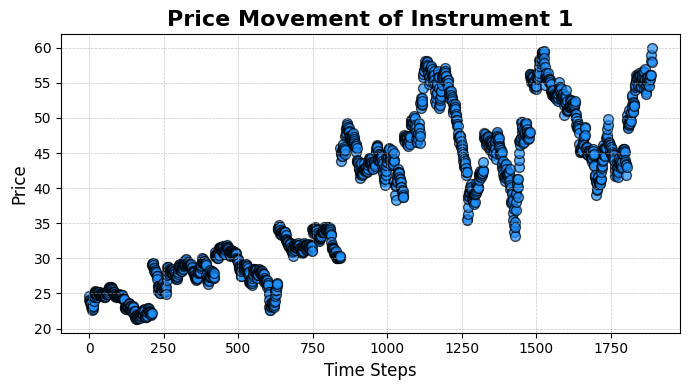

In [13]:
# Scatter plot of the first instrument.

plt.figure(figsize=(7, 4))
plt.scatter(first_instrument.index, first_instrument['price'], color='dodgerblue', alpha=0.7, edgecolor='black', s=50)

plt.title('Price Movement of Instrument 1', fontsize=16, fontweight='bold')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Price', fontsize=12)

plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()


### 4. Feature Engineering

#### Returns

The goal of this project is to predict the **expected returns** and **volatility**. The time series contains the **price** of a certain financial instrument at a given time. What I am going to do now is use the information that I have to create a new feature. To do this I need to understand the relationship between **price** and **returns**.

Simply put a return is a change in price. This can be measured as a percentage change:

$$
R_{t} = \frac{P_{t}-P_{t-1}}{P_{t-1}}
$$

Where $R_{t}$ is the return at a given time.

Logarithmic (or continuously compounded) returns transform price ratios into a log scale. They are consistent across scales and can be summed to compute multi-period returns, making them useful when performing time series modeling or statistical analysis, when aggregating returns over multiple periods or modeling in continuous time. Under certain conditions, Log returns follow a normal distribution, which simplifies modeling and analysis.


For small price changes, log returns are nearly equal to simple returns:

$$
ln\left(\frac{P_{t}}{P_{t-1}}\right) \approx \frac{P_{t}-P_{t-1}}{P_{t-1}}
$$

#### Volatility

Volatility is a statistical measure of the **dispersion** of a financial asset's returns. It reflects *how much the price of an asset fluctuates over a given period* and is commonly used as a measure of risk in financial markets.

It is usually expressed as the **standard deviation** of returns over a period.

In [14]:
# Log return calculation

first_instrument["Log Return"] = np.log(first_instrument["price"] / first_instrument["price"].shift(1))

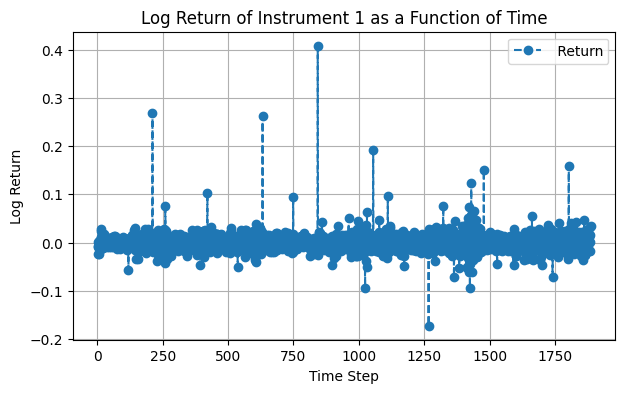

In [15]:
# Visualizing Returns

plt.figure(figsize=(7, 4))
plt.plot(first_instrument.index, first_instrument["Log Return"], marker='o', label=" Return", linestyle='--')

plt.title("Log Return of Instrument 1 as a Function of Time")
plt.xlabel("Time Step")
plt.ylabel("Log Return")
plt.legend()
plt.grid()
plt.show()

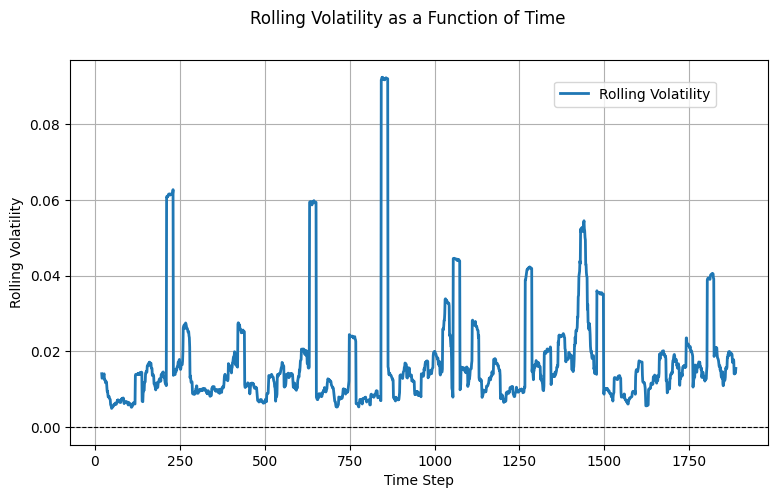

In [16]:
# Define rolling window size
rolling_window = 20  

# Calculate rolling standard deviation of log returns (volatility)
first_instrument["Rolling Volatility"] = first_instrument["Log Return"].rolling(window=rolling_window).std()

fig, ax1 = plt.subplots(figsize=(9, 5))

# Plot rolling volatility 
ax1.plot(first_instrument.index, first_instrument["Rolling Volatility"], label="Rolling Volatility", linewidth=2)
ax1.set_ylabel("Rolling Volatility")
ax1.tick_params(axis='y')
ax1.set_xlabel("Time Step")


fig.suptitle("Rolling Volatility as a Function of Time")
ax1.axhline(0, color='black', linestyle='--', linewidth=0.8)  
ax1.grid()

fig.legend(loc="upper right", bbox_to_anchor=(0.85, 0.85))
plt.show()


#### Quick note on how to choose a suitable window size for rolling statistics

Determining the right window size for rolling volatility depends on the characteristics of the data and the type of analysis being performed.

The window size should be based on the data *frequency* and the *scale* at which volatility is going to be analyzed.

For example, if the data represents daily observations (which is likely the case here), a common choice is 20 periods (approximately one month of trading days).

Bottom line: experiment with different window sizes! A rule of thumb is that shorter windows capture short-term fluctuations and longer ones smooth out noise and highlight long-term volatility trends.




#### Seasonality

An important aspect of time series analysis is identifying patterns or dependencies over time: for instance returns can be lower or greater in certain parts of the year, or there's some kind of pattern that repeats in periods of weeks/months etc.

In this particular case, the time index consists only of sequential time steps, so it's not possible to study seasonality since the explicit calendar dates are missing. However explore *oscilatory behaviour* in the data is doable with tools like **FFT**

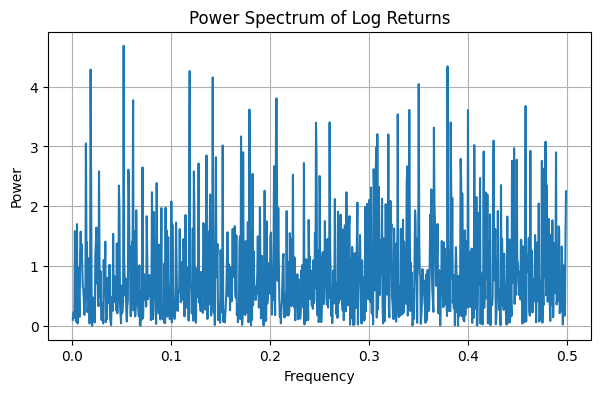

Dominant Period: 19.45 time steps


In [18]:
# FFT for Periodicity

# Perform FFT on the Log Return series
fft_vals = np.fft.fft(first_instrument["Log Return"].dropna())  # Drop NaN values
fft_freqs = np.fft.fftfreq(len(fft_vals))  # Get corresponding frequencies

# Identify dominant frequencies (periodicity)
fft_power = np.abs(fft_vals) ** 2
dominant_freq = fft_freqs[np.argmax(fft_power[1:])]  # Exclude zero frequency
dominant_period = 1 / abs(dominant_freq)  # Convert frequency to period

# Plot the power spectrum
plt.figure(figsize=(7, 4))
plt.plot(fft_freqs[1:len(fft_vals)//2], fft_power[1:len(fft_vals)//2])  # Positive frequencies only
plt.title("Power Spectrum of Log Returns")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.grid()
plt.show()

print(f"Dominant Period: {dominant_period:.2f} time steps")



This power spectrum does not exhibit a dominant frequency, which would typically manifest as a sharp, isolated peak. This indicates that the log returns  do not follow a strongly periodic or cyclical pattern. In this particular case filtering the data based on specific frequencies is unlikely to reveal meaningful seasonal components.

Many financial time series exhibit characteristics of a random walk, where returns are mostly uncorrelated and dominated by stochastic processes. The lack of periodic components aligns with this behavior.

### Train-test split

In time series forecasting, the training and testing split is still important, but the approach differs from typical machine learning tasks due to the sequential nature of time series data.

There are several factor to take into account when doing the split:  including the frequency of your data, the forecast horizon you're interested in, **model selection** and the overall length of your dataset.

In [ ]:
from sklearn.model_selection import train_test_split

X = first_instrument[["price"]]
y = first_instrument[["Log Return"]]

# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Display the sizes of the splits
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


### Introducing lag features

Lag features are time-shifted versions of the original time series data. They are going to be used as input features because they help capture temporal dependencies into the model.

For example, at time t, the value of a certain feature is 10 and the value at time t-1 is 9. Then the value of the Lag 1
feature at time t is 9

Then:

$$
Lag1(t) = feature(t-1)
$$

And so on, if I defined a Lag 2 feature:

$$
Lag2(t) = feature(t-2)
$$

In [20]:
# Create lag features

for lag in range(1, 6):  # Create 1 to 5 lag features
    X_train[f'lag_{lag}'] = X_train['price'].shift(lag)
    X_test[f'lag_{lag}'] = X_test['price'].shift(lag)


In [21]:
X_train.head()

,price,lag_1,lag_2,lag_3,lag_4,lag_5
0,24.59,NaN,NaN,NaN,NaN,NaN
1,24.00,24.59,NaN,NaN,NaN,NaN
2,24.01,24.00,24.59,NaN,NaN,NaN
3,23.82,24.01,24.00,24.59,NaN,NaN
4,23.62,23.82,24.01,24.00,24.59,NaN


### Rolling statistics

Rolling statistics are a set of statistical measures calculated over a *fixed-size sliding window* on a time series. 

As the window moves through the data, the statistics are recalculated using the observations within the current window. These statistics help to understand the local properties of the time series and can be used for feature engineering, trend analysis, or detecting anomalies.

In [22]:
# Create rolling mean and rolling std features

window_sizes = [3, 5, 10]
for window in window_sizes:
    X_train[f'rolling_mean_{window}'] = X_train['price'].rolling(window=window).mean()
    X_train[f'rolling_std_{window}'] = X_train['price'].rolling(window=window).std()

    X_test[f'rolling_mean_{window}'] = X_test['price'].rolling(window=window).mean()
    X_test[f'rolling_std_{window}'] = X_test['price'].rolling(window=window).std()


### Exponential Moving Average (EMA)

Is a type of moving average used in time series analysis to smooth data and highlight trends over time.

Unlike the simple moving average (SMA), which gives equal weight to all data points in the calculation window, the EMA assigns *greater weight to more recent observations*. This makes the EMA more responsive to recent changes.

In [23]:
# Create EMA features

spans = [3, 5, 10]
for span in spans:
    X_train[f'ema_{span}'] = X_train['price'].ewm(span=span, adjust=False).mean()
    X_test[f'ema_{span}'] = X_test['price'].ewm(span=span, adjust=False).mean()


In [26]:
# Fill NaNs with appropriate values (in this example I choose a backward fill)
X_train.bfill(inplace=True)
X_test.bfill(inplace=True)

In [27]:
X_train.head()

,price,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean_3,rolling_std_3,rolling_mean_5,rolling_std_5,rolling_mean_10,rolling_std_10,ema_3,ema_5,ema_10
0,24.59,24.59,24.59,24.59,24.59,24.59,24.200000,0.337787,24.008,0.362174,23.692,0.473446,24.590000,24.590000,24.590000
1,24.00,24.59,24.59,24.59,24.59,24.59,24.200000,0.337787,24.008,0.362174,23.692,0.473446,24.295000,24.393333,24.482727
2,24.01,24.00,24.59,24.59,24.59,24.59,24.200000,0.337787,24.008,0.362174,23.692,0.473446,24.152500,24.265556,24.396777
3,23.82,24.01,24.00,24.59,24.59,24.59,23.943333,0.106927,24.008,0.362174,23.692,0.473446,23.986250,24.117037,24.291908
4,23.62,23.82,24.01,24.00,24.59,24.59,23.816667,0.195021,24.008,0.362174,23.692,0.473446,23.803125,23.951358,24.169743


This are the new features that we have engenieered to train the data on!

### 5. Model Selection and Training

I will choose an RF model as my base model

The idea then is to encapsulate the entire process in a custom class, standardizing preprocessing, hyperparameter tuning, and model training. This approach reduces code duplication and ensures consistency across different models and parameter spaces. 

<ins>Note</ins>: y_train contains one null value. I have to deal with so as the ml models can be trained properly. In this particular case, because there is only one, I'll just remove the corresponding row.

In [32]:
# Combine X_train and y_train into a DataFrame for easy removal of rows

train_data = pd.concat([X_train, y_train], axis=1)

In [33]:
# Drop rows where y_train is NaN
train_data = train_data.dropna(subset=['Log Return'])  

# Split back into X_train and y_train
X_train = train_data.drop(columns=['Log Return'])
y_train = train_data['Log Return']

In [28]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

def train_model_pipeline(model, param_grid, X_train, y_train, X_test, y_test, 
                         n_splits=5, train_size=500, test_size=100):
    """
    Train a regression model with time-series cross-validation and hyperparameter tuning.
    
    Parameters:
        model: The machine learning model (e.g., XGBRegressor(), RandomForestRegressor()).
        param_grid: Dictionary of hyperparameters for GridSearchCV.
        X_train, y_train: Training dataset.
        X_test, y_test: Test dataset.
        n_splits: Number of CV splits.
        train_size: Maximum training window size.
        test_size: Test window size.
    
    Returns:
        best_model: The trained model with best parameters.
        best_params: Best hyperparameters found by GridSearchCV.
        mse, mae, r2: Performance metrics.
    """
    
    # Define time-series cross-validation strategy
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, max_train_size=train_size)
    
    # Perform Grid Search
    grid_search = GridSearchCV(
        estimator=model,   
        param_grid=param_grid,
        cv=tscv,
        scoring="neg_mean_squared_error",
        verbose=1,
        n_jobs=-1
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Get best parameters
    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)
    
    # Train the model with best parameters
    best_model = model.__class__(**best_params, random_state=42)  # Initialize with best params
    best_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = best_model.predict(X_test)
    
    # Evaluate performance
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"MSE: {mse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"R² Score: {r2:.6f}")
    
    return best_model, best_params, mse, mae, r2


In [34]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

best_rf, rf_params, rf_mse, rf_mae, rf_r2 = train_model_pipeline(
    RandomForestRegressor(), rf_param_grid, X_train, y_train, X_test, y_test
)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
MSE: 0.000208
MAE: 0.009870
R² Score: 0.277572


The fact that the MSE and MAE are small is generally desirable, but this fact alone is not necessary to conclude that the model's performance is good. The scale of the data has to be taken into account. This values can be small due to the fact that the data itself is very small:

In [37]:
print('The mean value of the Log Returns is', float(f"{first_instrument['Log Return'].mean():.2g}"))

The mean value of the Log Returns is 0.00047


And this is a very small number indeed.

But the number to pay attention to is the R-squared coefficient. This metric measures the *proportion of the variance in the target variable that is explained by the predictions*. It quantifies how well the model captures the variability of the data relative to a simple baseline model (usually the mean).

The fact that the R-squared coefficient is close to .27 means that there is room for improvement. I will try now to use a different model. 

In [35]:
from xgboost import XGBRegressor

In [36]:
xgb_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.1],
    "lambda": [1, 2]
}

best_xgb, xgb_params, xgb_mse, xgb_mae, xgb_r2 = train_model_pipeline(
    XGBRegressor(), xgb_param_grid, X_train, y_train, X_test, y_test
)


Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'lambda': 2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
MSE: 0.000123
MAE: 0.007655
R² Score: 0.571862


#### Feature importance and selection

Not every feature contributes the same way to the model's decision-making process. Feature importance quantifies the impact each feature has.

#### Why Is Feature Importance Useful?

Understanding which variable/s drive predictions, the model interpretability improves. Equally important is to eliminate the ones which are not important, to reduce model complexity. This is called *feature selection*

Removing noisy or irrelevant features can improve generalization, thus enhancing model performance. Is important to always remember that a simpler model is less likely to overfit to training data.



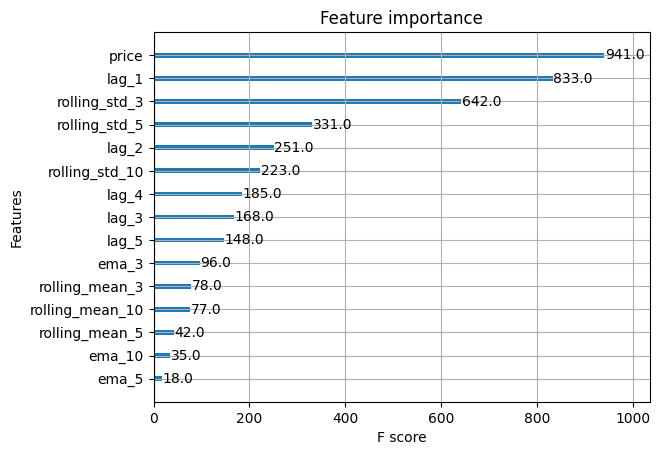

In [38]:
from xgboost import plot_importance

# Plot feature importance
plot_importance(best_xgb, importance_type='weight')  # Other options: 'gain', 'cover'
plt.show()

XGBoost library allows to clasify feature importance using different criterias.

Another more robust approach to feature importance is to use SHAP values

Unlike built-in feature importance, SHAP not only explains the actual impact of each feature on predictions but also considers how features interact with each other. It works for any model, but it’s especially effective for tree-based models like XGBoost.

In [39]:
import shap

# Compute SHAP values
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_train)

shap_importance = np.abs(shap_values.values).mean(axis=0)   # Calculate mean absolute SHAP value for each feature

# Create DataFrame with SHAP importance
shap_df = pd.DataFrame({"Feature": X_train.columns, "SHAP Importance": shap_importance})
shap_df = shap_df.sort_values(by="SHAP Importance", ascending=False)
shap_df.reset_index(drop=True, inplace=True)

c:\Users\ezequ\Documents\Python\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


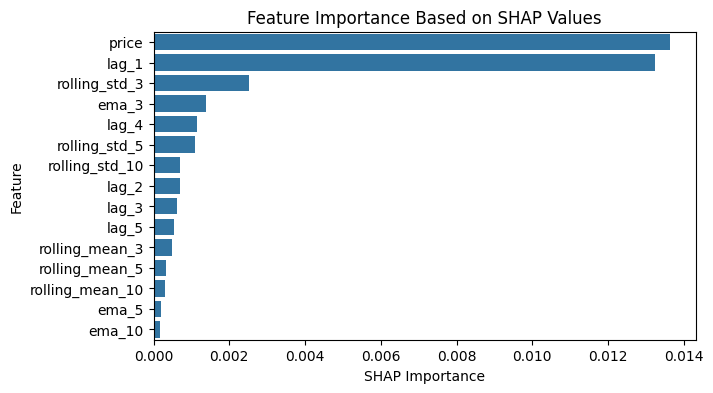

In [42]:
import seaborn as sns

# Plot SHAP feature importance

plt.figure(figsize=(7, 4))
sns.barplot(x="SHAP Importance", y="Feature", data=shap_df)

plt.xlabel("SHAP Importance")
plt.ylabel("Feature")
plt.title("Feature Importance Based on SHAP Values")

plt.show()

In [43]:
# Drop features with very low SHAP importance 
important_features = shap_df[shap_df["SHAP Importance"] > 0.0005]["Feature"].tolist()

# Select only these features
X_train_selected = X_train[important_features]
X_test_selected = X_test[important_features]

In [45]:
xgb_param_grid = {
    "n_estimators": [100, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0]
}

best_selected_xgb, xgb_selected_params, xgb_selected_mse, xgb_selected_mae, xgb_selected_r2 = train_model_pipeline(
    XGBRegressor(), xgb_param_grid, X_train_selected, y_train, X_test_selected, y_test
)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}
MSE: 0.000106
MAE: 0.006950
R² Score: 0.631663
